# Исследование маркетинговой аналитики Яндекс.Афиши

В данном проекте будет проведен анализ данных Яндекс.Афиши. Это данные с июня 2017 по конец мая 2018 года: лог сервера с данными о посещениях сайта, выгрузка заказов за этот период и статистика рекламных расходов.

Цель исследования состоит в том, чтобы определить, от каких источников трафика необходимо отказаться, а какие источники трафика выбрать в качестве приоритетных, чтобы корректно перераспределить маркетинговый бюджет.

Задачи исследования:
* определить, как клиенты пользуются сервисом - рассчитать метрики **DAU, WAU, MAU, Retention Rate, продолжительность пользовательской сессии, количество посещений сайта пользователем**
* установить, когда пользователи делают первые покупки на сайте - рассчитать, сколько **времени проходит от первого посещения сайта до первой покупки**
* выяснить, сколько денег приносит компании каждый клиент - рассчитать показатели **среднего чека, LTV**
* оценить расходы на маркетинг - рассчитать **общую сумму расходов на маркетинг, показатель CAC**
* определить, когда расходы на привлечение клиента окупаются - рассчитать **ROMI**

<a id="Старт"></a>

**Содержание**:

* [Шаг 1. Подготовка данных к анализу](#1)
    * [Импорт библиотек и загрузка данных](#1.1)
    * [Получение общей информации о данных](#1.2)
    * [Переименование столбцов](#1.3)
    * [Изменение типов данных](#1.4)
* [Шаг 2. Рассчет метрик и построение графиков](#2)
    * [Продуктовые метрики](#2.1)
        * [Показатели DAU, WAU, MAU](#2.1.1)
        * [Среднее количество посещений сайта в день](#2.1.2)
        * [Типичная продолжительность пользовательской сессии](#2.1.3)
        * [Показатель Retention Rate](#2.1.4)
    * [Метрики электронной коммерции](#2.2)
        * [Количество дней от посещения сайта до покупки](#2.2.1)
        * [Среднее количество покупок на одного покупателя](#2.2.2)
        * [Средний чек](#2.2.3)
        * [Показатель LTV](#2.2.4)
    * [Маркетинговые метрики](#2.3)
        * [Расходы на маркетинг по источникам](#2.3.1)
        * [Средний САС на покупателя](#2.3.2)
        * [Показатель ROMI](#2.3.3)
* [Шаг 3. Результаты исследования](#3)
    * [Определение приоритетных источников трафика](#3.1)
    * [Выводы по каждому виду метрик](#3.2)
    * [Определение перспективных когорт](#3.3)

## Шаг 1. Подготовка данных к анализу <a id="1"></a>

### 1.1. Импорт библиотек и загрузка данных <a id="1.1"></a>

На первом этапе импортируем необходимые в исследовании библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

Также считаем данные о визитах, заказах и расходах и запишем их в переменные visits, orders, costs. Кроме того, дадим названия таблицам - "визиты", "заказы" и "расходы".

In [2]:
visits = pd.read_csv('visits_log.csv')
visits.name = 'визиты'

orders = pd.read_csv('orders_log.csv') 
orders.name = 'заказы'

costs = pd.read_csv('costs.csv')
costs.name = 'расходы'

In [3]:
dataframes = [visits, orders, costs]

[Возврат к оглавлению](#Старт)

### 1.2. Получение общей информации о данных <a id="1.2"></a>

Изучим общую информацию по датафреймам - названия столцов и тип данных, содержащихся в них, а также посмотрим, есть ли в таблицах пропущенные значения.

In [4]:
for df in dataframes:
    display('Общая информация по датафрейму {}'.format(df.name))
    display(df.dtypes)
    display('Количество пропущенных значений в датафреме {}'.format(df.name))
    display(df.isna().sum())
  

'Общая информация по датафрейму визиты'

Device       object
End Ts       object
Source Id     int64
Start Ts     object
Uid          uint64
dtype: object

'Количество пропущенных значений в датафреме визиты'

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

'Общая информация по датафрейму заказы'

Buy Ts      object
Revenue    float64
Uid         uint64
dtype: object

'Количество пропущенных значений в датафреме заказы'

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

'Общая информация по датафрейму расходы'

source_id      int64
dt            object
costs        float64
dtype: object

'Количество пропущенных значений в датафреме расходы'

source_id    0
dt           0
costs        0
dtype: int64

1) Изучение структуры таблиц:

Рассмотрим, из каких столбцов состоят наши датафреймы:

**Visists** 

* Uid — уникальный идентификатор пользователя,
* Device — категория устройства пользователя,
* Start Ts — дата и время начала сессии,
* End Ts — дата и время окончания сессии,
* Source Id — идентификатор источника перехода на сайт

**Orders** 
* Uid — уникальный идентификатор пользователя,
* Buy Ts — дата и время заказа,
* Revenue — сумма заказа

**Costs** 
* Source_id — идентификатор рекламного источника,
* Dt — дата проведения рекламной кампании,
* Costs — расходы на эту кампанию.

Мы видим, что названия столбцов в таблицах "визиты" и "заказы" начинаются с прописных букв, кроме того, в названиях присутствуют пробелы. Далее заменим пробелы на нижнее подчеркивание, а прописные буквы поменяем на строчные, чтобы наименования всех столбцов были единообразными.

2) Изучение типов данных

Можно отметить, что некоторые столбцы требуют изменения типа данных со строкового на тип datetime:
* В таблице **visits** нам необходимо будет заменить столбцы с информацией о дате и времени начала и окончания сессии (**Start Ts, End Ts**) 
* В таблице **orders** - столбец с датой и временем заказа (**Buy Ts**) 
* В таблице **costs** - столбец с данными о дате проведения рекламной кампании (**Dt**)


3) Изучение пропущенных значений

Мы можем сделать вывод о том, что пропущенных значений в наших датафреймах не наблюдается.

[Возврат к оглавлению](#Старт)

### 1.3. Переименование столбцов <a id="1.3"></a>

В первую очередь переименуем столбцы, заменив в их названии пробелы на нижнее подчеркивание, поменяв все прописные буквы на строчные и подставив вместо аббревиатуры 'ts' слово 'time'.

In [5]:
for df in [visits, orders]:
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('ts', 'time')

Также в таблице visits добавим в названия столбцов слово 'session' для того, чтобы было интуитивно понятно, какие именно данные содержатся в данных столбцах

In [6]:
visits = visits.rename(columns={'end_time': 'session_end_time', 'start_time': 'session_start_time'})

В таблице costs переименуем столбец 'dt' в 'ad_date'.

In [7]:
costs = costs.rename(columns={'dt': 'ad_date'})

Далее проверим корректность осуществленных замен и выведем на экран 5 первых строк каждой таблицы.

In [8]:
for df in dataframes:
    display(df.name, df.head())
    print()

'визиты'

,device,end_time,source_id,start_time,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


'заказы'

,buy_time,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


'расходы'

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


[Возврат к оглавлению](#Старт)

### 1.4. Изменение типов данных <a id="1.4"></a>

Следующим шагом поменяем тип данных там, где это необходимо.

В таблице visits в столбцах 'session_end_time' и 'session_start_time' поменяем тип данных на datetime.

In [9]:
visits['session_end_time'] = pd.to_datetime(visits['session_end_time'])
visits['session_start_time'] = pd.to_datetime(visits['session_start_time'])

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   device              359400 non-null  object        
 1   session_end_time    359400 non-null  datetime64[ns]
 2   source_id           359400 non-null  int64         
 3   session_start_time  359400 non-null  datetime64[ns]
 4   uid                 359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


В таблице orders поменяем на тип datetime столбец 'buy_time'.

In [11]:
orders['buy_time'] = pd.to_datetime(orders['buy_time'])

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   buy_time  50415 non-null  datetime64[ns]
 1   revenue   50415 non-null  float64       
 2   uid       50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


В таблице costs заменим тип данных в столбце 'ad_date' на datetime. 

In [13]:
costs['ad_date'] = pd.to_datetime(costs['ad_date']) 

In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   ad_date    2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Таким образом, на данной шаге мы:

1. Изучили структуру датафреймов - из каких они состоят столбцов и какие данные содержат. 


2. Переименовали столбцы - записали все названия строчными буквами, пробелы заменили на нижнее подчеркивание, поменяли названия некоторых столбцов на более понятные (start_date и end_date заменили на session_start_date и session_end_date, а dt - на ad_date).


3. Поменяли тип данных в тех столбцах, где это было необходимо. К столбцам, требующим замены типа данных, мы отнесли столбцы с данными о дате и времени посещений сайта, покупок и рекламных кампаний. Мы заменили строковй тип данных на тип datetime.


4. Отметили, что в датафреймах нет пропущенных значений.

[Возврат к оглавлению](#Старт)

## Шаг 2. Рассчет метрик и построение графиков. <a id="2"></a>

На данном шаге посчитаем метрики трёх видов:
* продуктовые,
* метрики электронной коммерции,
* маркетинговые.

### 2.1. Продуктовые метрики <a id="2.1"></a>

#### 2.1.1. Показатели DAU, WAU и MAU <a id="2.1.1"></a>

Рассчитаем метрики
* DAU - количество уникальных пользователей в день;
* WAU - количество уникальных пользователей в неделю;
* MAU - количество уникальных пользователей в месяц.

Вычислим средние значения этих метрик за весь период с июня 2017 по конец мая 2018 года и отобразим изменения метрик во времени на графиках

Для того, чтобы рассчитать данные метрики, добавим в датафрйем visits данные о месяце, неделе (в виде первого дня недели) и дате посещения пользователями сайта.

In [15]:
visits['session_month'] = visits['session_start_time'].astype('datetime64[M]')  # выделение месяца

visits['session_week'] = visits['session_start_time'].astype('datetime64[W]')  # выделение первого дня недели

visits['session_date'] = visits['session_start_time'].dt.date  # выделение даты

Посчитаем **DAU**, сгруппировав данные по дате посещения сайта и посчитав количество уникальных пользователей в каждую из дат.
Выведем первые пять строк получившейся таблицы.

In [16]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).reset_index()
dau_total.columns = ['session_date', 'dau']
dau_total.head(5)

,session_date,dau
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


Далее построим график изменения данного показателя во времени.

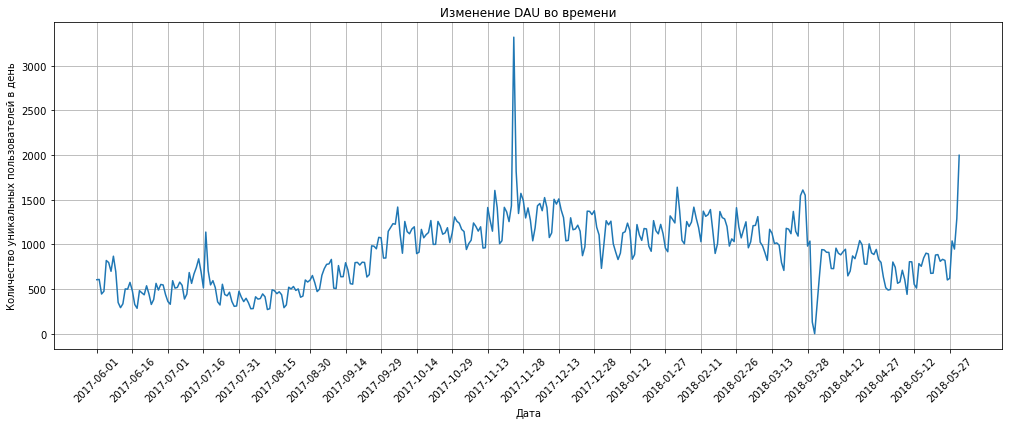

In [17]:
ax_dau = dau_total.plot.line(x='session_date', y='dau', figsize=(17, 6), grid=True, legend=False)

ax_dau.set_title('Изменение DAU во времени')
ax_dau.set_ylabel('Количество уникальных пользователей в день')
ax_dau.set_xlabel('Дата')

plt.xticks(
    np.arange(
        dau_total['session_date'].min(), 
        dau_total['session_date'].max() +
        pd.to_timedelta('1 day'), 
        pd.to_timedelta('15 day')
    ), 
    rotation = 45
)

plt.show()

На графике видно, что показатель DAU достиг наибольшего значения в ноябре 2017 г. (между 13 и 28 ноября). 

Возможно, в эти даты была проведена массовая рекламная кампания или пользователи хотели приобрести билеты на какое-то очень популярное мероприятие.

Что касается минимального значения данного показателя, он наблюдается спустя несколько дней после 28 марта 2018 г.

Теперь рассчитаем показатель **WAU**. Для этого сгрупируем данные по неделям и посчитаем количество уникальных посетителей.

In [18]:
wau_total = visits.groupby('session_week').agg({'uid': 'nunique'}).reset_index()
wau_total.columns = ['session_week', 'wau']
wau_total.head(5)

,session_week,wau
0,2017-06-01,4082
1,2017-06-08,3311
2,2017-06-15,2844
3,2017-06-22,3079
4,2017-06-29,3055


Также построим график изменения метрики во времени.

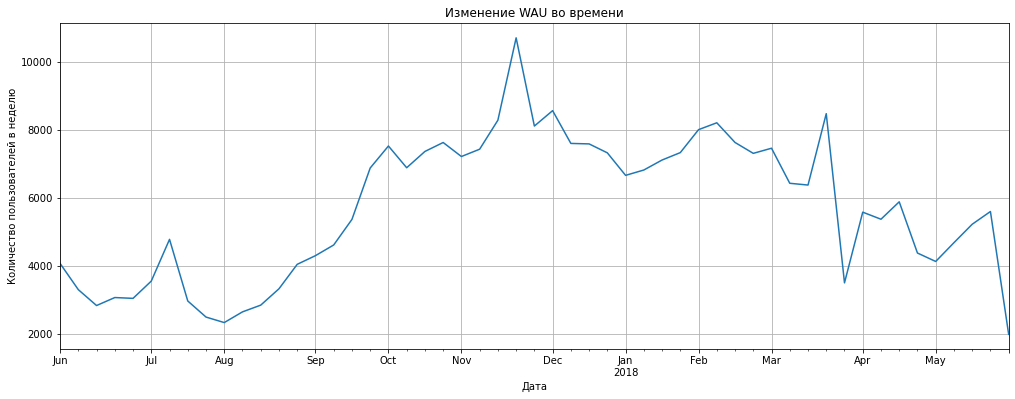

In [19]:
ax_wau = wau_total.plot.line(x='session_week', y='wau', figsize=(17, 6), grid=True, legend=False)

ax_wau.set_title('Изменение WAU во времени')
ax_wau.set_ylabel('Количество пользователей в неделю')
ax_wau.set_xlabel('Дата')

plt.show()

На графике изменения WAU мы также видим, что максимального значения метрика достигла примерно на 2-3 неделю ноября 2017 г. 

При этом, в отличие от DAU, минимальное значение данный показетель прнимает не в марте 2018 г., а в июне и августе 2017 г.

То есть, несмотря на то, что в отдельно взятый день марта 2018 г. количество уникальных посетителей было очень мало, в рамках целой недели данный показатель был не таким низким.

Рассчитаем показатель MAU тем же способом, что и WAU, DAU, но в качестве переменной для группировки возьмем месяц посещения сайта.

In [20]:
mau_total = visits.groupby('session_month').agg({'uid': 'nunique'}).reset_index()
mau_total.columns = ['session_month', 'mau']
mau_total.head()

,session_month,mau
0,2017-06-01,13259
1,2017-07-01,14183
2,2017-08-01,11631
3,2017-09-01,18975
4,2017-10-01,29692


Построим график.

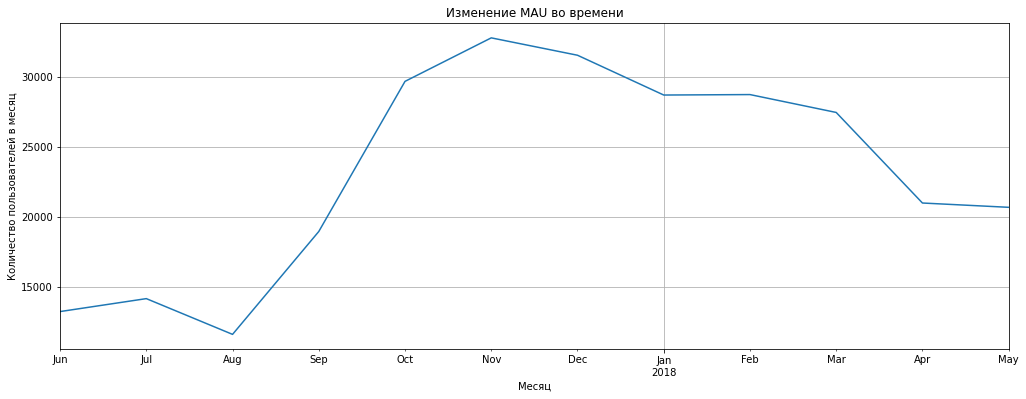

In [21]:
ax_mau = mau_total.plot.line(x='session_month', y='mau', figsize=(17, 6), grid=True, legend=False)

ax_mau.set_title('Изменение MAU во времени')
ax_mau.set_ylabel('Количество пользователей в месяц')
ax_mau.set_xlabel('Месяц')


plt.show()

На данном графике видно резкое увеличение количества уникальных посетителей в месяц после августа 2017 г. Своего пика MAU достиг в ноябре 2017 г., после чего наблюдалось постепенное снижение значения указанной метрики.

Рассчитаем средние показатели метрик DAU, WAU, MAU:

In [22]:
print('Показатель DAU =', int(dau_total['dau'].mean()))
print('Показатель WAU =', int(wau_total['wau'].mean()))
print('Показатель MAU =', int(mau_total['mau'].mean()))

Показатель DAU = 907
Показатель WAU = 5724
Показатель MAU = 23228


Таким образом, изучив графики изменения метрик DAU, WAU, MAU в период с июня 2017 по конец мая 2018 года, мы можем отметить, что пик каждой из этих метрик приходится на ноябрь 2017 г. А минимальные значения приходятся на июнь и август 2017 г. для показетелей WAU и MAU и на март 2018 г. для показателя DAU.

[Возврат к оглавлению](#Старт)

#### 2.1.2.  Среднее количество посещений сайта в день <a id="2.1.2"></a>

Определим, сколько раз за день пользователи в среднем заходят на сайт. 

In [23]:
sessions_avg = visits.groupby(['session_date', 'uid']).agg({'session_start_time': 'count'}).reset_index()
sessions_avg.columns = ['session_date', 'uid', 'number_of_visits']
sessions_avg.head()

,session_date,uid,number_of_visits
0,2017-06-01,32197920403662046,1
1,2017-06-01,184148767273119549,2
2,2017-06-01,254239507810036143,1
3,2017-06-01,258099436367309303,1
4,2017-06-01,300776506671194537,1


In [24]:
print('Среднее количество посещений сайта, которое приходится на каждого пользователя в день = {:.2f}'
      .format(sessions_avg['number_of_visits']
              .mean()))

Среднее количество посещений сайта, которое приходится на каждого пользователя в день = 1.09


Построим график, отражающий изменения метрики во времени.

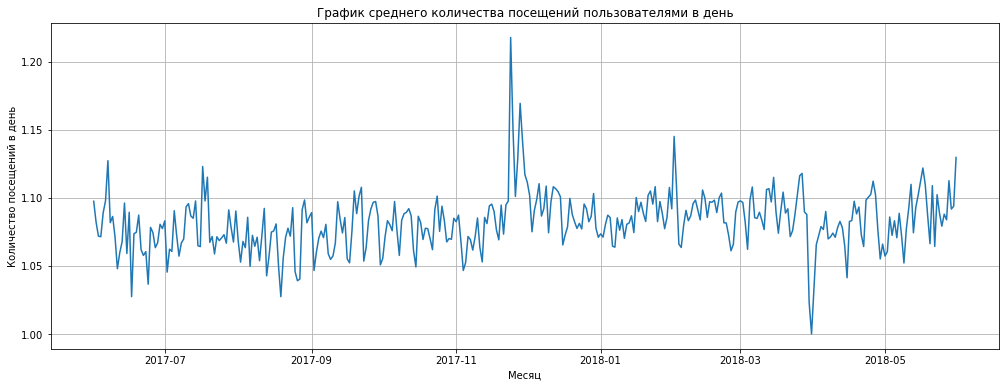

In [25]:
average_visits = sessions_avg.groupby('session_date').agg({'number_of_visits': 'mean'}).reset_index()

ax_avg_visits = average_visits.plot.line(x='session_date', y='number_of_visits', figsize=(17, 6), grid=True, legend=False)
ax_avg_visits.set_title('График среднего количества посещений пользователями в день')
ax_avg_visits.set_ylabel('Количество посещений в день')
ax_avg_visits.set_xlabel('Месяц')


plt.show()

Мы посчитали количество посещений сайта Яндекс.Афиши, которое приходится на каждого пользователя в день. Этот показатель составляет 1.09, то есть в среднем пользователи заходят на сайт около раза в день. 

Изучив график, мы можем отметить, что больше всего посещений на пользователя приходится на вторую половину ноября 2017 г., когда данный показатель принимает значение больше 1.2 посещений в день, а меньше всего - конец марта 2018 г., когда данная метрика составляет всего 1 посещение в день.

[Возврат к оглавлению](#Старт)

#### 2.1.3.  Типичная продолжительность пользовательской сессии <a id="2.1.3"></a>

Изучим, сколько времени пользователи проводят на сайте.

Для этого найдем разницу между началом и окончанием сессии и отрбразим данную разницу в виде количества минут.

In [26]:
visits['session_time'] = visits['session_end_time'] - visits['session_start_time']
visits['session_time'] = visits['session_time'] / np.timedelta64(1, 'm')
visits.head()

,device,session_end_time,source_id,session_start_time,uid,session_month,session_week,session_date,session_time
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27,0.0


Посмотрим на распределение данного показателя.

In [27]:
visits['session_time'].describe()

count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_time, dtype: float64

Мы видим, что по какой-то причине минимальное значение продолжительности пользовательской сессии орицательно. Посмотрим, какие строки содержат в себе отрицательные значения по данному показателю.

In [28]:
visits.query('session_time < 0')

,device,session_end_time,source_id,session_start_time,uid,session_month,session_week,session_date,session_time
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-01,2018-03-22,2018-03-25,-32.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-01,2018-03-22,2018-03-25,-46.0


Мы видим, что таких строк, где окончание сессии раньше, чем ее начало, две, возможно, это был какой-то технический сбой. Количество таких наблюдений очень мало, поэтому исключим их.

In [29]:
visits = visits.query('session_time > 0')

Узнаем продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, построим график распределения.

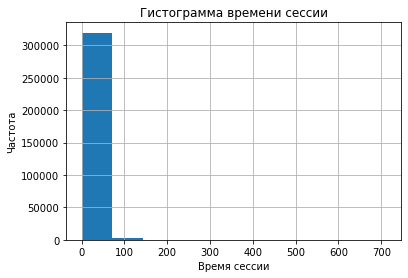

In [30]:
duration = visits.groupby(['uid', 'session_start_time']).agg({'session_time': 'sum'})
ax_duration1 = duration['session_time'].hist()
ax_duration1.set_title('Гистограмма времени сессии')
ax_duration1.set_xlabel('Время сессии')
ax_duration1.set_ylabel('Частота')

plt.show()

Так как большинство сессий длятся не дольше 50-60 минут, укажем в качестве диапазона значения до 50 минут.

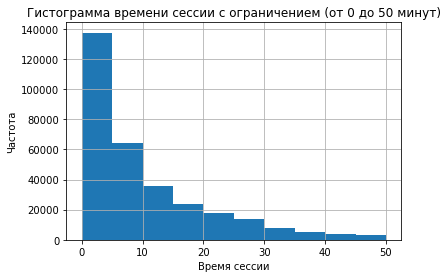

In [31]:
ax_duration2 = duration['session_time'].hist(range=(0, 50))
ax_duration2.set_title('Гистограмма времени сессии с ограничением (от 0 до 50 минут)')
ax_duration2.set_xlabel('Время сессии')
ax_duration2.set_ylabel('Частота')

plt.show()

Мы видим, что распределение продолжительности пользовательских сессий не является нормальным, большинство сессий длятся меньше 5 минут, при этом есть небольшое количество сессий, длительность которых стремится к 700 минутам.

Так как распределение не является нормальным, посчитаем в дополнении к среднему значению медиану и моду.

In [32]:
print('Средняя продолжительность пользовательской сессии = {:.2f} минут'.format(duration['session_time'].mean()))
print('Типичная (медианная) продолжительность пользовательской сессии = {:.2f} минут'.format(duration['session_time'].median()))
print('Мода продолжительности пользовательской сессии = {:.2f} минут'.format(duration['session_time'].mode().mean()))

Средняя продолжительность пользовательской сессии = 11.90 минут
Типичная (медианная) продолжительность пользовательской сессии = 6.00 минут
Мода продолжительности пользовательской сессии = 1.00 минут


Таким образом, мы можем сказать, что типичный пользователь находится на сайте Яндекс.Афиша около 6 минут за сессию. При этом сессии некоторых пользователей длятся вплоть до 700 минут (возможно, в поисках интересного мероприятия они забывают закрыть сайт и оставляют включенным компьютер), поэтому среднее практически в два раза больше, чем медиана, почти 12 минут. А мода продолжительности пользовательской сессии составляет 1 минуту, то есть наиболее часто мы можем встретить пользователей, которые проводят на сайте 1 минуту.

[Возврат к оглавлению](#Старт)

#### 2.1.4. Показатель Retention Rate <a id="2.1.4"></a>

Рассчитаем Retention Rate, применяя когортный анализ.

Для этого найдем первый месяц посещения пользователем сайта, сгруппировав таблицу visits по пользователю.

In [33]:
first_activity_date = visits.groupby('uid')['session_month'].min().reset_index()
first_activity_date = first_activity_date.rename(columns={'session_month': 'first_session_month'})
first_activity_date.head()

,uid,first_session_month
0,11863502262781,2018-03-01
1,49537067089222,2018-02-01
2,297729379853735,2017-06-01
3,313578113262317,2017-09-01
4,325320750514679,2017-09-01


Добавим информацию о самой ранней дате посещения пользователем сайта в общую таблицу visits.

In [34]:
visits = visits.merge(first_activity_date, on='uid')

Найдем разницу между месяцем пользовательской сессии и месяцем первого посещения сайта и выразим данный показатель в количестве месяцев.

In [35]:
visits['lifetime'] = (visits['session_month'] - visits['first_session_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

Сформируем когорты, то есть группы людей, объединённых одним и тем же событием, произошедшим в определённый период времени. В данном случае когорты будут образованы на основе месяца первого посещения сайта.

Сгруппируем таблицу visits по первому месяцу посещения сайта и количеству месяцев, прошедших с этой даты, и посчитаем количество уникальных пользователей.

In [36]:
cohorts = visits.groupby(['first_session_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()
cohorts = cohorts.rename(columns={'uid': 'number_of_users'})
cohorts.head()

,first_session_month,lifetime,number_of_users
0,2017-06-01,0,11885
1,2017-06-01,1,900
2,2017-06-01,2,606
3,2017-06-01,3,710
4,2017-06-01,4,777


Посчитаем количество людей в каждой когорте. Для этого выберем наблюдения в нулевом периоде, т.е. в том же месяце, когда было осуществлено первое посещение сайта пользователем.

In [37]:
initial_users = cohorts[cohorts['lifetime'] == 0][['first_session_month', 'number_of_users']]
initial_users = initial_users.rename(columns={'number_of_users':'initial_users'}) 
initial_users.head()

,first_session_month,initial_users
0,2017-06-01,11885
12,2017-07-01,11825
23,2017-08-01,9214
33,2017-09-01,15125
42,2017-10-01,23538


Добавим в таблицу cohorts информацию о количестве пользователей в каждой когорте. 

Рассчитаем соотношение между количеством активных пользователей в n-ый lifetime к количеству активных пользователей в 0-й lifetime, т.е. **retention rate**.

In [38]:
cohorts = cohorts.merge(initial_users, on='first_session_month') 
cohorts = cohorts.query('lifetime != 0')

In [39]:
cohorts['retention_rate'] = cohorts['number_of_users'] / cohorts['initial_users']

Построим сводную таблицу с данными о показателе retantion rate (rr) в каждый из lifetime (кроме 0-го, т.к. в 0-й lifetime rr=1)

In [40]:
retention_pivot = cohorts.pivot_table(
    index='first_session_month', 
    columns='lifetime', 
    values='retention_rate', 
    aggfunc='sum'
)

retention_pivot

lifetime,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,
2017-06-01,0.075726,0.050989,0.059739,0.065377,0.067480,0.057720,0.056121,0.050989,0.049727,0.038115,0.043921
2017-07-01,0.054545,0.050402,0.055645,0.056660,0.046512,0.044059,0.044059,0.037886,0.027315,0.027061,NaN
2017-08-01,0.074452,0.060451,0.060451,0.047970,0.041459,0.036249,0.037660,0.027133,0.024745,NaN,NaN
2017-09-01,0.083570,0.067769,0.049322,0.038083,0.036959,0.035372,0.022876,0.022744,NaN,NaN,NaN
2017-10-01,0.078129,0.050811,0.037811,0.033648,0.031184,0.020775,0.019798,NaN,NaN,NaN,NaN
2017-11-01,0.078183,0.042733,0.037824,0.032593,0.021729,0.020602,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.054668,0.036518,0.030178,0.019453,0.017716,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.057794,0.037817,0.024352,0.019249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.056561,0.024290,0.019184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Покажем изменения метрики во времени в виде тепловой карты. 

In [41]:
retention_pivot.index = retention_pivot.index.strftime("%m/%Y")

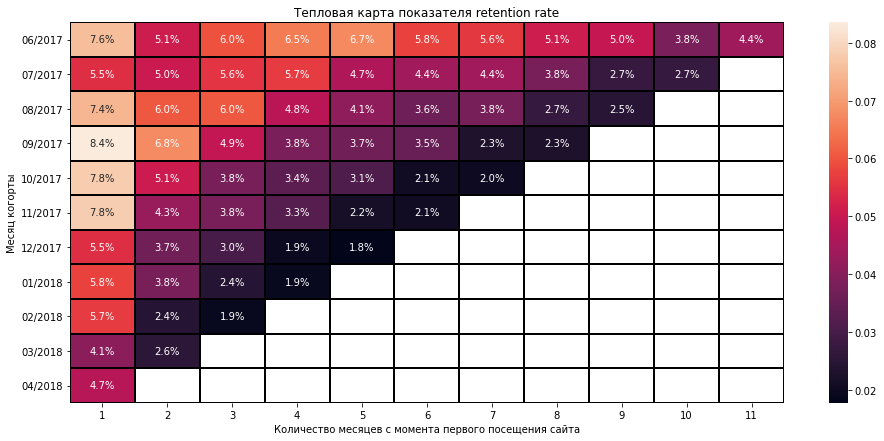

In [42]:
plt.figure(figsize=(16, 7))

ax_heatmap = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black')

ax_heatmap.set_title('Тепловая карта показателя retention rate')
ax_heatmap.set_xlabel('Количество месяцев с момента первого посещения сайта')
ax_heatmap.set_ylabel('Месяц когорты')

plt.show()

Найдем средний retention rate на второй месяц «жизни» когорт.

In [43]:
lifetime_2 = cohorts[cohorts['lifetime'] == 1][['first_session_month', 'retention_rate']]

print('Средний retention rate на второй месяц «жизни» когорт: {:.2%}'.format(lifetime_2['retention_rate'].mean()))

Средний retention rate на второй месяц «жизни» когорт: 6.38%


Изучив график, мы видим, что довольно малое количество пользователей повторно заходят на сайт в последующие после первого посещения месяцы. Это, вероятно, связано с особенностями сервиса, так как билеты на различные мероприятия люди, как правило, редко приобретают на ежемесячной основе.

Начиная со второго месяца "жизни" когорты показатель retention rate опускается в среднем до 6.38%, то снижаясь, то возрастая в последующие месяцы.

В некоторых когортах retention rate во второй месяц гораздо выше, чем у других когорт (июнь, август, сентябрь, октябрь, ноябрь 2017 г.), особенно выделяется когорта сентября 2017 г., в которой данный показатель составляет 8.4%. Возможно, в этот месяц проводилась промо акция или какой-либо другой вид активности по привлечению пользователей. Наиболее низкий показатель retention rate на второй месяц "жизни" когорт - в марте 2018 г., в этот месяц он составляет 4.1%. 

В целом можно отметить, что в когортах после ноября 2017 г. наблюдается спад в показателе retention rate. Например, уже на третий месяц "жизни" когорты февраля 2018 г. показатель retention rate составил 1.9%. До подобного значения показатель не опускался ни в одной из когорт до декабря 2017 г. На это необходимо обратить внимание и изучить, почему после ноября 2017 г. пользователи гораздо менее охотно возвращаются на сайт Яндекс.Афиши.

[Возврат к оглавлению](#Старт)

### Вывод

Таким образом на данной этапе мы рассчитали и проанализировали следующие метрики:
* **DAU, WAU, MAU** - выяснили, что пик по данным метрикам приходится на ноябрь 2017 г. (в дальнейшем стоит изучить причину, которая привела такое большое количество пользователей на сайт в эти даты, если это было вызвано активностью со стороны нашей компании, возможно, такую практику стоит повторить и в будущем). А наименишие значения данные показатели принимают в марте 2018 г. (показетель DAU) и июне и августе 2017 г. (показатели WAU и MAU).


* **Среднее количество посещений сайта в день**, которое приходится на каждого пользователя - оно составило около 1-го посещения в день (ожидаемое для нашего сервиса значение, т.к. мало кто из пользователей обычно заходит несколько раз в день на сайт, чтобы узнать о каком-то мероприятии или приобрести на него билет)


* **Типичную продолжительность пользовательской сессии** - она составила около 6 минут (то есть в среднем наши пользователи успевают за 6 минут сделать все необходимое на сайте и покинуть его или же не находят ничего для себя интересного и поэтому уходят - в дальнешем стоит детальнее изучить, что пользователи успевают сделать за 6 минут на сайте, возможно им что-то не нравится и это вынуждает их быстро покинуть сайт)


* **Retention rate** по когортам - средний показатель на второй год существования когорты составляет 6.38% (то есть лишь небольшая часть пользователей в дальнейшем возвращается, чтобы снова купить билеты на мероприятия или узнать нужную информацию по мероприятиям). Также мы выяснили, что в когортах, начиная с декабря 2017 г. показатель retention rate значительно снижается по сравнению с предыдущими когортами (важно выяснить причину этого, возможно, это связано сезонностью и тем, что в холодное время года люди не очень охотно посещают различные мероприятия, но также эта причина может быть связана с какими-либо изменениями в нашем сервисе, которые не нравятся нашим пользователям). 


[Возврат к оглавлению](#Старт)

### 2.2. Метрики электронной коммерции <a id="2.2"></a>

#### 2.2.1. Количество дней от посещения сайта до покупки <a id="2.2.1"></a>

Изучим, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 

Добавим в таблицу orders информацию о месяце покупки и оставим только те наблюдения, в которых покупки были совершены до июня 2018 г. (т.к. мы знаем, что полные данные у нас представлены только за период с июня 2017 г. по май 2018 г.)

In [44]:
orders['buy_time_month'] = orders['buy_time'].astype('datetime64[M]')

In [45]:
orders = orders.query('buy_time_month < "2018-06-01"')

In [46]:
orders.head()

,buy_time,revenue,uid,buy_time_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


Далее сгруппируем данные в таблице visits по пользователю и найдем дату первого посещения пользователем сайта.

In [47]:
first_visit = visits.groupby('uid').agg({'session_start_time': 'min'})
first_visit = first_visit.rename(columns={'session_start_time': 'first_visit_time'})

Также найдем дату первой покупки из таблицы orders.

In [48]:
first_order = orders.groupby('uid').agg({'buy_time': 'min'})
first_order = first_order.rename(columns={'buy_time': 'first_buy_time'})

Объединим таблицы с данный о первом посещении сайта пользователем и первой его покупкой.

In [49]:
visits_orders = first_visit.merge(first_order, on='uid').reset_index()

Найдем разницу между датой первой покупки и датой первого посещения сайта пользователем и выразим данное значение в днях.

In [50]:
visits_orders['visit_to_purchase_time'] = visits_orders['first_buy_time'] - visits_orders['first_visit_time']

visits_orders['visit_to_purchase_time'] = (pd.to_timedelta(visits_orders['visit_to_purchase_time']) 
                                           / np.timedelta64(1, 'D'))

visits_orders.head()

,uid,first_visit_time,first_buy_time,visit_to_purchase_time
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106.959722
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.000000
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0.054861
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0.822222
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.000000


In [51]:
visits_orders.query('visit_to_purchase_time < 0').head()

,uid,first_visit_time,first_buy_time,visit_to_purchase_time
481,246917802374455080,2017-07-17 17:58:00,2017-07-15 06:53:00,-2.461806
644,331505068949795458,2017-09-14 16:05:00,2017-08-25 13:37:00,-20.102778
1007,504121461129059724,2018-05-06 15:02:00,2018-05-02 09:20:00,-4.237500
1097,543499019308129333,2018-04-24 15:01:00,2018-04-24 10:11:00,-0.201389
1475,745110943593938635,2018-02-13 18:44:00,2018-02-13 18:40:00,-0.002778


Мы видим, что в данных по количеству дней от первого визита до первой покупки наблюдаются отрицательные значения, которые вероятно связаны с какими-то техническими ошибками. Рассмотрим их количество относительно общего количества наблюдений.

In [52]:
(len(visits_orders.query('visit_to_purchase_time < 0')) / len(visits_orders)) * 100

0.5404656319290465

Количество наблюдений с отрицательными значениями не очень велико, оно составляет чуть больше 0.5%, поэтому исключим указанные значения при анализе.

In [53]:
visits_orders = visits_orders.query('visit_to_purchase_time > 0')

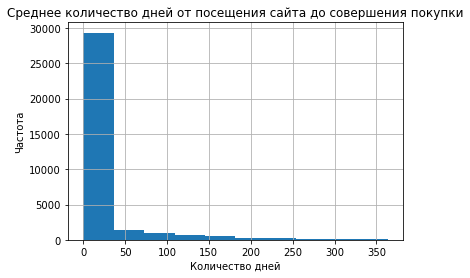

In [54]:
ax_visits = visits_orders['visit_to_purchase_time'].hist()
ax_visits.set_title('Среднее количество дней от посещения сайта до совершения покупки')
ax_visits.set_xlabel('Количество дней')
ax_visits.set_ylabel('Частота')
plt.show()

На графике видно, что распределение отличается от нормального, поэтому в качестве меры среднего возьмем медиану.

In [55]:
from_visit_to_purchase = visits_orders.groupby('uid').agg({'visit_to_purchase_time': 'mean'})

print('Среднее количество дней от первого посещения сайта до первой покупки {:.2f}'
      .format(from_visit_to_purchase['visit_to_purchase_time']
              .median()))

Среднее количество дней от первого посещения сайта до первой покупки 0.01


Таким образом, типичный пользователь покупает билеты на мероприятия на нашем сервисе в нулевой день, то есть меньше чем за день после первого посещения сайта.

[Возврат к оглавлению](#Старт)

#### 2.2.2. Среднее количество покупок на одного покупателя <a id="2.2.2"></a>

Рассчитаем среднее количество покупок на одного покупателя за за 6 месяцев.

Первым шагом добавим в таблицу orders информацию о дате и месяц первой покупки клиента.

In [56]:
first_order = first_order.reset_index()
orders = orders.merge(first_order, on='uid')

In [57]:
orders['first_buy_month'] = orders['first_buy_time'].astype('datetime64[M]')

Найдем количество месяцев между датой покупки и датой первой покупки для формирования "возраста" когорт. Также оставим наблюдения только за 6 месяцев.

In [58]:
orders['lifetime'] = (orders['buy_time'] - orders['first_buy_time']) / np.timedelta64(1, 'M')
orders['lifetime'] = orders['lifetime'].round().astype('int')

In [59]:
half_year_orders = orders.query('lifetime < 6')

Сделаем группировку по месяцу первой покупки и посчитаем количество покупателей в когорте.

In [60]:
number_of_buyers = half_year_orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
number_of_buyers.columns = ['first_buy_month', 'n_buyers']
number_of_buyers.head()

,first_buy_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Также посчитаем количество покупок по месяцам в течение 6 месяцев "жизни" когорты.

In [61]:
avg_orders = half_year_orders.groupby(['first_buy_month', 'lifetime']).agg({'buy_time': 'count'}).reset_index()
avg_orders.head()

,first_buy_month,lifetime,buy_time
0,2017-06-01,0,2355
1,2017-06-01,1,147
2,2017-06-01,2,152
3,2017-06-01,3,236
4,2017-06-01,4,278


Соединим таблицы с данными о количестве покупателей в когорте и количестве покупок в различные месяцы существования когорты.

In [62]:
avg_orders = avg_orders.merge(number_of_buyers, on='first_buy_month')

Разделим количество покупок на количество покупателей в когорте, чтобы найти, сколько в среднем покупают клиенты.

In [63]:
avg_orders['order_per_buyer'] = avg_orders['buy_time'] / avg_orders['n_buyers']

Построим сводную таблицу, в которой покажем когорты, по которым есть полная информация за 6 месяцев, а также среднее количество покупок на клиента в каждый из месяцев существования когорты.

In [64]:
avg_orders_pivot = avg_orders.pivot_table(index='first_buy_month', columns='lifetime', values='order_per_buyer', aggfunc='sum').reset_index()
avg_orders_pivot = avg_orders_pivot.loc[0:7]
avg_orders_pivot = avg_orders_pivot.set_index('first_buy_month')
avg_orders_pivot

lifetime,0,1,2,3,4,5
first_buy_month,,,,,,
2017-06-01,1.164113,0.072664,0.075136,0.116658,0.137420,0.100840
2017-07-01,1.138846,0.047842,0.058762,0.054602,0.037441,0.034841
2017-08-01,1.140146,0.071533,0.071533,0.064234,0.048175,0.043796
2017-09-01,1.147230,0.075940,0.063154,0.057342,0.030996,0.043394
2017-10-01,1.147926,0.063134,0.041935,0.029724,0.028802,0.021659
2017-11-01,1.213183,0.063465,0.053908,0.044107,0.031610,0.015682
2017-12-01,1.154917,0.055213,0.048825,0.041296,0.018480,0.022359
2018-01-01,1.128669,0.062556,0.044174,0.022235,0.017492,0.002075


Просуммируем среднее количество покупок по месяцам, чтобы узнать сколько в среднем в каждой когорте делают покупок за 6 месяцев.

In [65]:
avg_orders_pivot.sum(axis=1)

first_buy_month
2017-06-01    1.666831
2017-07-01    1.372335
2017-08-01    1.439416
2017-09-01    1.418055
2017-10-01    1.333180
2017-11-01    1.421955
2017-12-01    1.341091
2018-01-01    1.277201
dtype: float64

In [66]:
print('Среднее количество покупок на покупателя за 6 мес. = {:.2f}'.format(avg_orders_pivot.sum(axis=1).mean()))

Среднее количество покупок на покупателя за 6 мес. = 1.41


Мы видим, что наибольшее количество покупок за 6 месяцев в среднем было сделано покупателями из самой первой когорты июня 2017 г., а меньше всего - покупателями из когорты января 2018 г. В среднем покупатель из июньской когорты сделал 1.7 покупок за 6 месяцев, а покупатель из январской когорты - только 1.3.

[Возврат к оглавлению](#Старт)

#### 2.2.3. Средний чек <a id="2.2.3"></a>

Рассчитаем средний чек.

Для этого сгруппируем данные по месяцу покупки и посчитаем общую выручку за данный месяц и количество покупок.
Затем поделим выручку на количество покупок для того, чтобы узнать сумму среднего чека в конкретный месяц.

In [67]:
revenue_by_user = orders.groupby('buy_time_month').agg({'revenue': 'sum', 'buy_time': 'count'})
revenue_by_user['avg_check'] = revenue_by_user['revenue'] / revenue_by_user['buy_time']
revenue_by_user

,revenue,buy_time,avg_check
buy_time_month,,,
2017-06-01,9557.49,2354,4.060106
2017-07-01,12539.47,2363,5.306589
2017-08-01,8758.78,1807,4.847139
2017-09-01,18345.51,3387,5.416448
2017-10-01,27987.70,5679,4.928280
2017-11-01,27069.93,5659,4.783518
2017-12-01,36388.60,6218,5.852139
2018-01-01,19417.13,4721,4.112927
2018-02-01,25560.54,5281,4.840095


In [68]:
print('Средний чек за весь период составляет {:.2f} y.e.'.format(revenue_by_user['avg_check'].mean()))

Средний чек за весь период составляет 4.96 y.e.


Построим график, отражающий изменения метрики во времени;

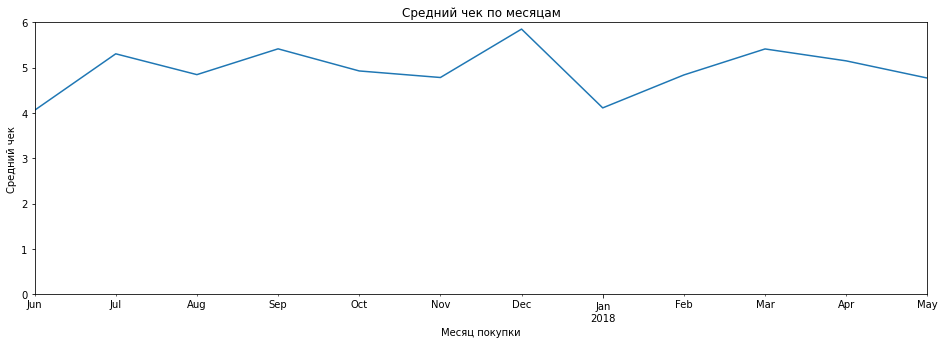

In [69]:
ax_avg_check = revenue_by_user.plot(kind='line', y='avg_check', figsize=(16, 5), legend=False)
ax_avg_check.set_ylim([0, 6])
ax_avg_check.set_title('Средний чек по месяцам')
ax_avg_check.set_xlabel('Месяц покупки')
ax_avg_check.set_ylabel('Средний чек')

plt.show()

Мы видим, что за наблюдаемый период средний чек вариировался примерно от 4 до 6 y.e. Наибольший средний чек приходится на декабрь 2017 г., а наименьший - на июнь 2017 г. и январь 2018 г. 

Возможно, тот факт, что самый высокий средний чек приходится на декабрь, может быть объяснен новогодними представлениями, на которые покупатели приобрели билеты в декабре. Обычно такие мероприятия не очень дешевые, кроме того в одном заказе могли быть билеты на несколько человек, например, целую семью, что также могло повысить средний чек в этом месяце. В дальнейшем можно подробнее изучить, количество билетов в каждом заказе в декабре по сравнению с другими месяцами, а также стоимость каждого мероприятия в заказе. Также можно изучить динамику за предыдущие периоды и понять, проявляется ли в изменениях среднего чека некоторая сезонность, или это связано с конкретными мероприятиями или маркетиноговыми активностями.

Наименьшие значения среднего чека в июне и январе, вероятно, могут быть обусловлены теми же причинами - возможно, в январе и июне заказы в основном были оформлены на не очень дорогостоящие мероприятия или количество билетов в каждом заказе было близко к одному.

Средний чек за весь рассматриваемый период - 4.96 у.е.

[Возврат к оглавлению](#Старт)

#### 2.2.4. Показатель LTV <a id="2.2.4"></a>

Выясним, как меняется LTV (итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок).
Рассчитаем средний LTV по когортам за 6 месяцев, учитывая, что маржинальность сервиса — 100%. 

Сформируем когорты по месяцу первой покупки и посчитаем количество клиентов в каждой из когорт.

In [70]:
cohort_sizes = (orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index())
cohort_sizes.columns = ['first_buy_month', 'n_buyers']

Посчитаем валовую прибыль по каждой когорте (т.к. маржинальность равна 100%, наша валовая прибыль будет равна выручке).

In [71]:
orders_cohorts = orders.groupby(['first_buy_month', 'buy_time_month']).agg({'revenue': 'sum'}).reset_index()

Объединим данные по количеству клиентов в каждой когорте и валовой прибыли.

In [72]:
orders_cohorts = orders_cohorts.merge(cohort_sizes, on='first_buy_month')

Посчитаем возраст когорт, найдя разницу между месяцем покупки и первым месяем покупки. Выразим его в количестве месяцев.

In [73]:
orders_cohorts['age'] = (orders_cohorts['buy_time_month'] -  orders_cohorts['first_buy_month']) / np.timedelta64(1, 'M')
orders_cohorts['age'] = orders_cohorts['age'].round().astype('int')

Найдем показатель ltv в каждой когорте в зависимости от возраста, разделим валовую прибыль на количество покупателей.

In [74]:
orders_cohorts['ltv'] = orders_cohorts['revenue'] / orders_cohorts['n_buyers']

Посчитаем накопленный показатель ltv, применив метод cumsum.

In [75]:
output = orders_cohorts.pivot_table(index='first_buy_month', columns='age', values='ltv', aggfunc='mean').round(2)
output = output.cumsum(axis=1)

Отразим изменения метрики во времени на графике с помощью тепловой карты.

In [76]:
output.index = output.index.strftime("%m/%Y")

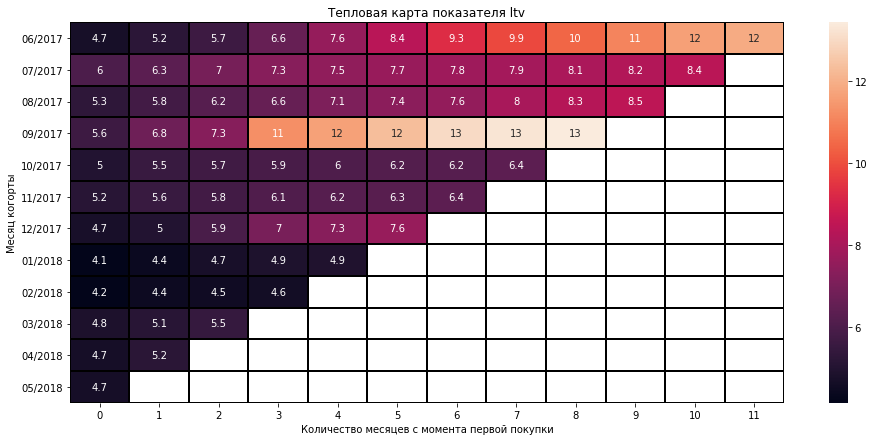

In [77]:
plt.figure(figsize=(16, 7))

ax_output = sns.heatmap(output, annot=True, linewidths=1, linecolor='black')

ax_output.set_title('Тепловая карта показателя ltv')
ax_output.set_xlabel('Количество месяцев с момента первой покупки')
ax_output.set_ylabel('Месяц когорты')

plt.show()

In [78]:
print('В среднем пользователи приносят за 6 месяцев жизни когорты {:.2f} у.е.'.format(round(output[6].mean(), 2)))

В среднем пользователи приносят за 6 месяцев жизни когорты 8.38 у.е.


Мы выяснили, что в среднем покупатели в когорте сентября 2017 г. принесли компании больше денег, чем покупатели из всех остальных когорт. Второй по данному показателю является когорта июня 2017 г. Мы видим, что показатель ltv ухудшается в когортах после сентября 2017 г. Так, на 5 месяц "жизни" ltv в когортах октября и ноября 2017 г. составляет меньше 6.5 у.е., т.е. он ниже чем данный показатель в любой из когорт до сентября 2017 г. Однако показатели в когорте декабря 2017 г. отличаются в лучшую сторону по сравнению со всеми остальными когортями после сентября 2017 г., в этой когорте наблюдается значительный рост на 3 год "жизни", благодаря которому ltv за полгода составляет 7.6 у.е.

Также мы рассчитали, что в среднем за 6 месяцев жизни когорты покупатели приносят компании 8.4 у.е., то есть для того, чтобы наши инвестиции в маркетинг окупались, нам необходимо тратить в среднем не более 8.4 у.е. на привлечения покупателя или же стремиться к повышению показателя ltv. Но подробные рассчеты стоимости привлечения клиента и окупаемости инвестиций будут осуществлены уже на следующем этапе.

[Возврат к оглавлению](#Старт)

### Вывод

Таким образом, на данном шаге мы проанализировали следующие метрики электронной коммерции:
* Среднее **время с момента первого посещения пользователем сайта до первой покупки** - мы поняли, что в среднем покупатели совершают покупки в нулевой день, т.е. в тот же день, когда они впервые посетили сайт, что хорошо для бизнеса.
* Среднее **количество покупок на одного покупателя** за 6 месяцев - мы выяснили, что в среднем на каждого покупателя приходится не больше 2 покупок за 6 месяцев, при этом наиболее высокий показатель наблюдается в когорте июня 2017 г. - 1.67 покупок, а наиболее низкий - в когорте января 2018 г. - 1.28 покупок.
* **Средний чек** - он составил 4.96 у.е. за покупку, при этом пик значений наблюдается в декабре 2017 г., а наименьшее значение - в январе 2018 г., что, возможно, связано с сезонностью - в декабре часто приобретают билеты на новогодние шоу, которые, как правило, довольно дорогие. В целом средний чек вариируется от 4 до 6 у.е. в зависимости от месяца покупки.
* **LTV** за 6  месяцев - в среднем за 6 месяцев жизни когорты пользователи приносят 8.38 у.е. При этом наиболее прибыльные - когорты сентября и июня 2017 г. При этом мы видим снижение показателя ltv после когорты сентября 2017 г. (за исключением декабря 2017 г.), т.е. пользователи в данных когортах покупают меньше, чем покупатели в более ранних когортах. В дальнейшем нам необходимо изучить причины, которые привели к снижению данной метрики.

[Возврат к оглавлению](#Старт)

### 2.3. Маркетинговые метрики <a id="2.3"></a>

#### 2.3.1. Расходы на маркетинг по источникам <a id="2.3.1"></a>

Выясним, как траты распределены по источникам и посчитаем общую сумму расходов на маркетинг. 

Сгруппируем данные по источнику трафика и посчитаем общую сумму расходов по каждой группе.

In [79]:
summed_costs = costs.groupby('source_id').agg({'costs': 'sum'})
summed_costs.sort_values(by='costs', ascending=False)

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


Мы видим, что больше всего расходов приходится на 3-й источник трафика, при этом сумма расходов на него более, чем в два раза больше, чем расходы на следующий по объему расходов 4й источник. Наименьшая сумма расходов приходится на 9-й источник. 

In [80]:
print('Общая сумма расходов на маркетинг = {:,} у.е.'.format(costs['costs'].sum()))

Общая сумма расходов на маркетинг = 329,131.62 у.е.


Добавим в таблицу расходов информацию о месяце рекламных расходов.

In [81]:
costs['ad_month'] = costs['ad_date'].astype('datetime64[M]')

Визуализируем изменения метрики во времени

In [82]:
costs_pivot = costs.pivot_table(index='ad_month', columns='source_id', values='costs', aggfunc='sum')

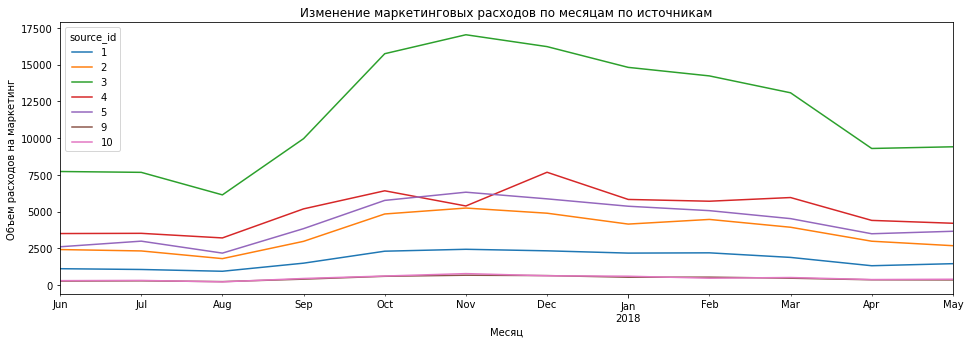

In [83]:
ax_costs_pivot = costs_pivot.plot.line(figsize=(16, 5))

ax_costs_pivot.set_title('Изменение маркетинговых расходов по месяцам по источникам')
ax_costs_pivot.set_xlabel('Месяц')
ax_costs_pivot.set_ylabel('Объем расходов на маркетинг')

plt.show()

На графике видно значительное различие в расходах на 3-й источник трафик и все остальные источники.
Также мы видим, что раходы по всем источникам трафика начинают расти после августа 2017 г. (наименее заметное изменение - по 9-му и 10-му источникам, их значения очень близки друг к другу и почти сливаются на графике). Практически по всем источникам наибольшая сумма расходов приходится на ноябрь 2017 г., а по 4 источнику - на декабрь 2017 г.

[Возврат к оглавлению](#Старт)

#### 2.3.2. Средний САС на покупателя <a id="2.3.2"></a>

Рассчитаем средний CAC, т.е. стоимость привлечения клиента - сумму денег, во сколько обходится новый клиент компании, для всего проекта и для каждого источника трафика. 

Для этого сгруппируем расходы по месяцу и просуммируем их по каждой группе.

In [84]:
average_costs = costs.groupby('ad_month').agg({'costs': 'sum'}).reset_index()

Добавим к таблице с размерами когорт информацию о сумме расходов в каждом месяце.

In [85]:
cac_report = cohort_sizes.merge(average_costs, left_on='first_buy_month', right_on='ad_month')

Рассчитаем показатель сас - поделим сумму расходов на количество клиентов в когорте.

In [86]:
cac_report['cac'] = cac_report['costs'] / cac_report['n_buyers']

cac_report[['ad_month', 'cac']].sort_values(by='cac', ascending=False)

,ad_month,cac
2,2017-08-01,10.796015
7,2018-01-01,9.937302
10,2018-04-01,9.793225
1,2017-07-01,9.485486
3,2017-09-01,9.441654
5,2017-11-01,9.288870
8,2018-02-01,8.962758
0,2017-06-01,8.905091
6,2017-12-01,8.741809
9,2018-03-01,8.608907


Построим график, отражающие изменение САС по месяцам.

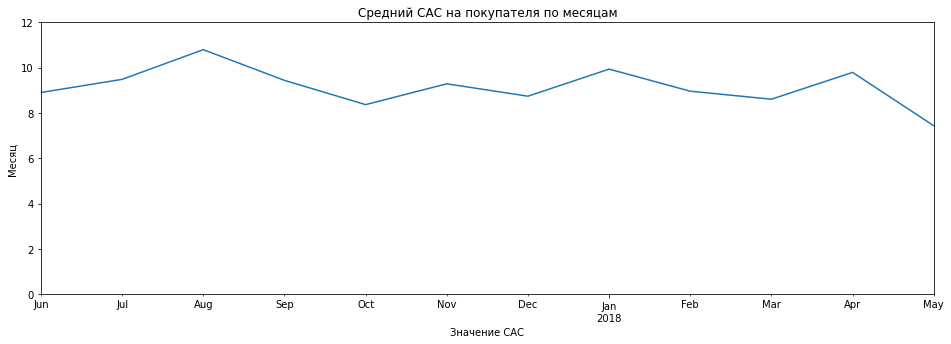

In [87]:
ax_mean_cac = cac_report.plot.line(x='ad_month', y='cac', figsize=(16, 5), legend=False)

ax_mean_cac.set_ylim([0, 12])
ax_mean_cac.set_title('Средний САС на покупателя по месяцам')
ax_mean_cac.set_ylabel('Месяц')
ax_mean_cac.set_xlabel('Значение САС')

plt.show()

In [88]:
print('Средний показатель cac = {:.2f} у.е.'.format(cac_report['cac'].mean()))

Средний показатель cac = 9.15 у.е.


Наиболее высокая стоимость привлечения клиента в августе 2017 г. Также в топ три наиболее дорогих по привлечению новых клиентов месяцев также входят январь и апрель 2018 г. 

Наиболее низкий показатель cac - в мае 2018 г.

А средний показатель САС по всем месяцам составляет 9.15 у.е.

Рассчитаем затраты по каждому источнику на определенный месяц. Для этого сгруппируем данные по источнику и месяцу расходов и просуммируем расходы внутри каждой группы.

In [89]:
costs_by_source = costs.groupby(['source_id', 'ad_month']).agg({'costs': 'sum'}).reset_index()
costs_by_source.head()

,source_id,ad_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Найдем первый источник трафика по каждому пользователю.

In [90]:
visits = visits.sort_values(by='session_start_time')
first_source = visits.groupby('uid')['source_id'].first().reset_index()
first_source.head()

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


Определим первый месяц покупки пользователем

In [91]:
first_buy_date = orders.groupby('uid').agg({'first_buy_month': 'min'}).reset_index()

Объединим таблицы, чтобы получить общий датафрейм с первым источником для пользователя и месяцем его первой покупки.

In [92]:
report_by_sources = first_buy_date.merge(first_source, on='uid')

In [93]:
report_by_sources.head()

,uid,first_buy_month,source_id
0,313578113262317,2018-01-01,2
1,1575281904278712,2017-06-01,10
2,2429014661409475,2017-10-01,3
3,2464366381792757,2018-01-01,5
4,2551852515556206,2017-11-01,5


Сгруппируем данные по заказам по месяцу первой покупки и источнику трафика, посчитаем количество уникальных пользователей.

In [94]:
orders_by_sources = report_by_sources.groupby(['first_buy_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()

In [95]:
cac_by_source = orders_by_sources.merge(costs_by_source, on='source_id')

Посчитаем сас по каждому источнику, разделив количество расходов на количество покупателей внутри каждой группы источника.

In [96]:
cac_by_source['cac'] = cac_by_source['costs'] / cac_by_source['uid']

In [97]:
(cac_by_source.groupby('source_id')
 .agg({'cac': 'mean'})
 .reset_index()
 .sort_values(by='cac', ascending=False))

,source_id,cac
2,3,15.948653
1,2,13.752094
4,5,8.213441
0,1,7.796774
3,4,7.297455
5,9,6.009246
6,10,5.513613


Наиболее дорогой по привлечению новых клиентов источник - 3-й, затем идет 2-й и значительно меньший по показателю 5-й источник. Наиболее дешевый - 6-й источник.

Отразим изменения CAC по месяцам внутри каждого источника на графике:

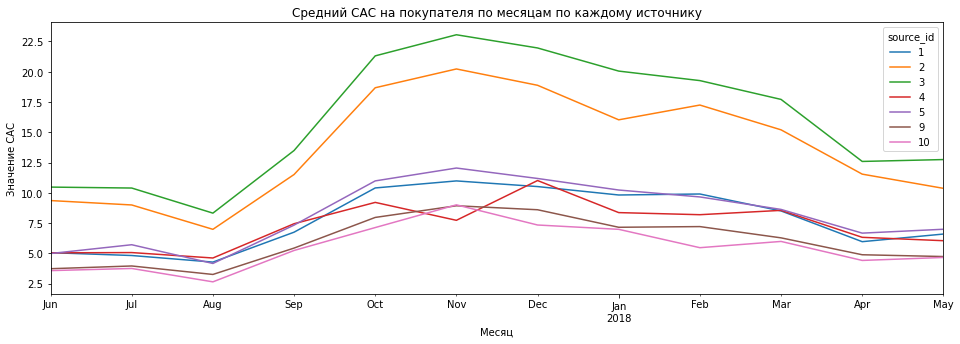

In [98]:
cac_pivot = cac_by_source.pivot_table(index='ad_month', columns='source_id', values='cac', aggfunc='mean')

ax_cac_pivot = cac_pivot.plot.line(figsize=(16, 5))

ax_cac_pivot.set_title('Средний САС на покупателя по месяцам по каждому источнику')
ax_cac_pivot.set_xlabel('Месяц')
ax_cac_pivot.set_ylabel('Значение САС')

plt.show()

На графике изменения показателя сас во времени мы видим, что 3-й источник такой же дорогой, как и на графике, на котором мы анализировали изменения абсолютных сумм расходов. Однако, в отличие от абсолютных сумм расходов на клиента, вторым по дороговизне привлечения пользователей является не 4-й или 5-й, а 2-й источник трафика. 

Показатель сас, как и общая сумма расходов на маркетинг, начинают расти в августе и пик практически по большинству источников траффика приходится на ноябрь 2017 г.

[Возврат к оглавлению](#Старт)

#### 2.3.3. Показатель ROMI <a id="2.3.3"></a>

Рассчитаем ROMI по когортам в разрезе источников.

Для этого в первую очередь найдем количество покупателей в каждой когорте, образованной по принципу месяц первой покупки и рекламный источник.

In [99]:
orders_with_sources = orders.merge(first_source, on='uid')
orders_with_sources.head()

,buy_time,revenue,uid,buy_time_month,first_buy_time,first_buy_month,lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,0,3


In [100]:
customers_by_sources = (orders_with_sources
                        .groupby(['first_buy_month', 'source_id'])
                        .agg({'uid': 'nunique'})
                        .reset_index())
customers_by_sources.head()

,first_buy_month,source_id,uid
0,2017-06-01,1,190
1,2017-06-01,2,232
2,2017-06-01,3,630
3,2017-06-01,4,410
4,2017-06-01,5,381


Сгруппируем данные по месяцу первой покупки, месяцу покупки и рекламному источнику и посчитаем сумму валовой прибыли (у нас она равна выручке) в каждой группе.

In [101]:
revenue_by_sources = (orders_with_sources
                      .groupby(['first_buy_month', 'buy_time_month', 'source_id'])
                      .agg({'revenue': 'sum'})
                      .reset_index())

revenue_by_sources.head()

,first_buy_month,buy_time_month,source_id,revenue
0,2017-06-01,2017-06-01,1,1326.73
1,2017-06-01,2017-06-01,2,1010.58
2,2017-06-01,2017-06-01,3,2760.27
3,2017-06-01,2017-06-01,4,1949.19
4,2017-06-01,2017-06-01,5,1928.60


In [102]:
report_for_ltv = revenue_by_sources.merge(customers_by_sources, on=['first_buy_month', 'source_id'])

Посчитаем ltv - поделим валовую прибыль на количество покупателей в когорте.

In [103]:
report_for_ltv['ltv'] = report_for_ltv['revenue'] / report_for_ltv['uid']
report_for_ltv.head()

,first_buy_month,buy_time_month,source_id,revenue,uid,ltv
0,2017-06-01,2017-06-01,1,1326.73,190,6.982789
1,2017-06-01,2017-07-01,1,421.09,190,2.216263
2,2017-06-01,2017-08-01,1,393.23,190,2.069632
3,2017-06-01,2017-09-01,1,422.88,190,2.225684
4,2017-06-01,2017-10-01,1,682.96,190,3.594526


Сгруппируем расходы по месяцу расходов и рекламному источнику, посчитаем сумму расходов в каждой из групп.

In [104]:
costs_for_cac = (costs
                 .groupby(['ad_month', 'source_id'])
                 .agg({'costs': 'sum'})
                 .reset_index())
costs_for_cac.head()

,ad_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


Объединим таблицу с расходами, сгруппированными по месяцу расходов и источником, - таблица costs_for_cac, с таблицей, хранящей данные по выручке в конкретный месяц и о количестве человек в когорте - report_for_ltv.

In [105]:
romi_report = costs_for_cac.merge(report_for_ltv, left_on=['ad_month', 'source_id'], right_on=['buy_time_month', 'source_id'])

Посчитаем сас - поделим расходы на количество покупателей в когорте, и romi - поделим ltv на cac для каждой когорты.

In [106]:
romi_report['cac'] = romi_report['costs'] / romi_report['uid']
romi_report['romi'] = romi_report['ltv'] / romi_report['cac']

Добавим информацию о возрасте когорты, посчитав количество месяцев, прошедших с даты первой покупки до даты покупки.

In [107]:
romi_report['age'] = pd.to_timedelta(romi_report['buy_time_month'] - romi_report['first_buy_month']) / np.timedelta64(1, 'M')
romi_report['age'] = romi_report['age'].round().astype('int')

In [108]:
romi_report.head()

,ad_month,source_id,costs,first_buy_month,buy_time_month,revenue,uid,ltv,cac,romi,age
0,2017-06-01,1,1125.61,2017-06-01,2017-06-01,1326.73,190,6.982789,5.924263,1.178676,0
1,2017-06-01,2,2427.38,2017-06-01,2017-06-01,1010.58,232,4.355948,10.462845,0.416325,0
2,2017-06-01,3,7731.65,2017-06-01,2017-06-01,2760.27,630,4.381381,12.272460,0.357009,0
3,2017-06-01,4,3514.80,2017-06-01,2017-06-01,1949.19,410,4.754122,8.572683,0.554566,0
4,2017-06-01,5,2616.12,2017-06-01,2017-06-01,1928.60,381,5.061942,6.866457,0.737199,0


Отобразим изменение ltv и romi во времени по каждому источнику трафика в виде тепловых карт.

In [109]:
sources = romi_report['source_id'].unique()

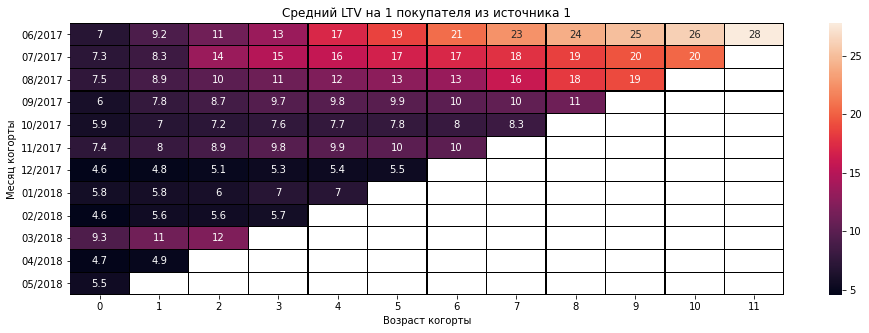

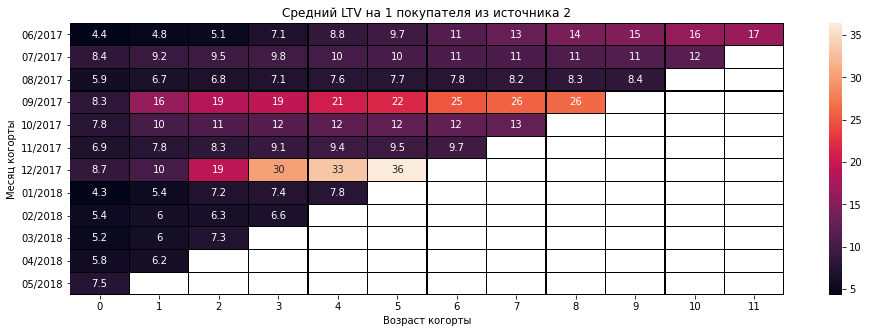

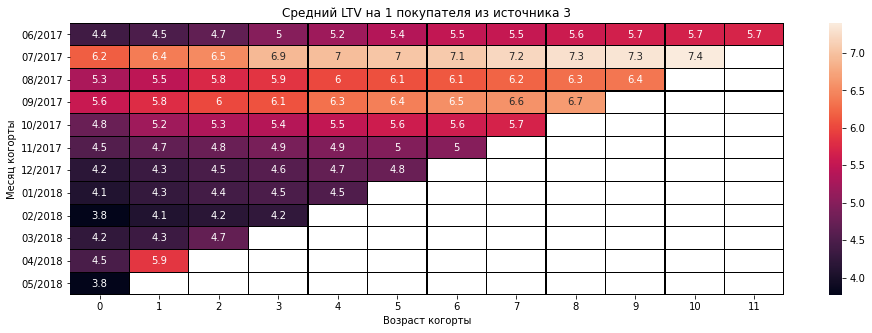

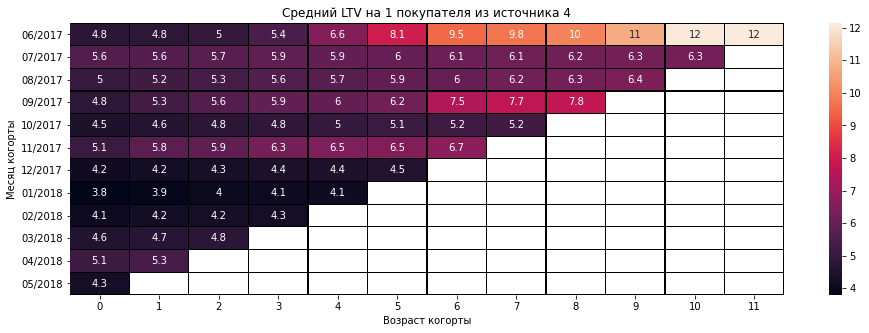

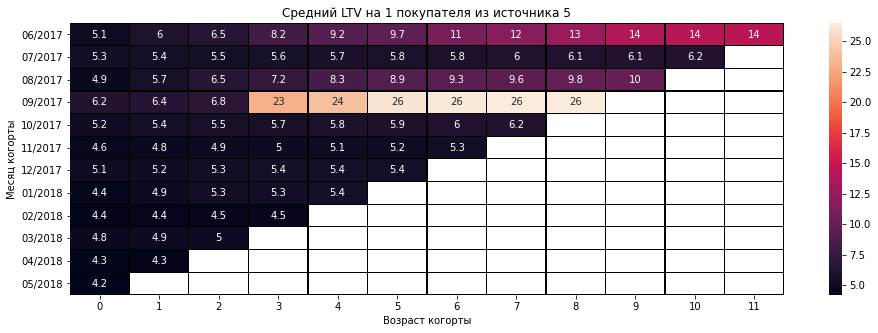

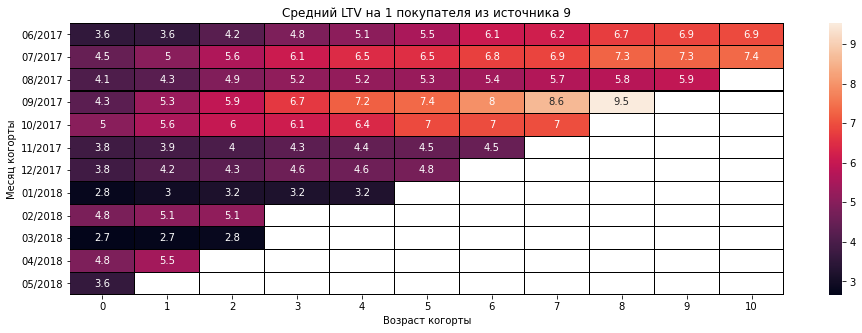

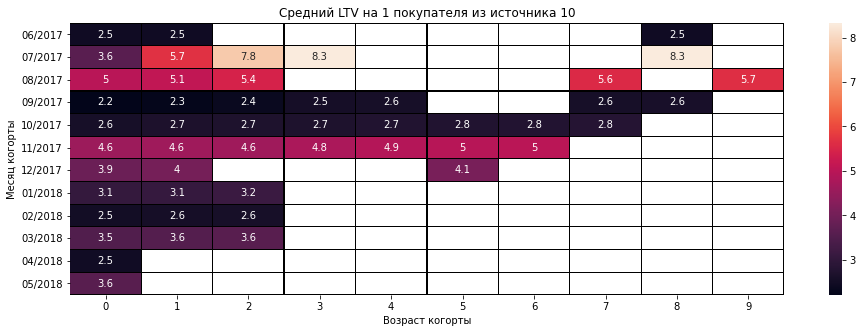

In [110]:
for source in sources:
    plt.figure(figsize=(16, 5))
    
    ltv_by_sources = (romi_report[romi_report['source_id'] == source]
              .pivot_table(index='first_buy_month', columns='age', values='ltv', aggfunc='mean'))
    ltv_by_sources.index = ltv_by_sources.index.strftime("%m/%Y")
    
    sns.heatmap(ltv_by_sources.cumsum(axis=1).round(2), annot=True, linewidths=0.2, linecolor='black')
    
    plt.title('Средний LTV на 1 покупателя из источника {}'.format(source))
    plt.xlabel('Возраст когорты')
    plt.ylabel('Месяц когорты')

По графику мы видим, что наиболее высокий ltv у 1-го и 2-го источников - по второму источнику максимальное значение ltv достигает 36 у.е. в когорте декабря 2017 г., а по первому источнику - 28 у.е. в когорте июня 2017 г. По первому источнику особенно выделяются когорта июня-августа 2017 г., а также марта 2018 г. По второму - выше всего показатели когорты декабря 2017г., также довольно высокие значения в когортах июня и сентября 2017г.

Наименее низкие показатели по 3-му и 10-му источникам. По 10-му источнику отсутствуют данные по нескольким месяцам, однако показатели по имеющимся данными не превышают значения 8.3 у.е. в лучший месяц. По 3-му источнику показатели не превышают 7.4 у.е. за весь рассматриваемый период.

Построим также тепловые карты для показателя ROMI по каждому из источников.

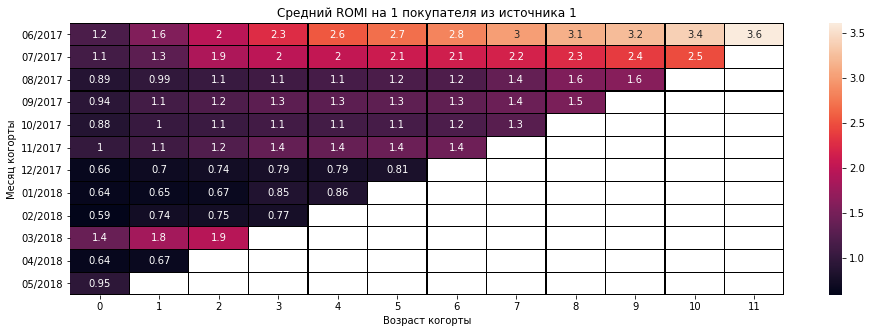

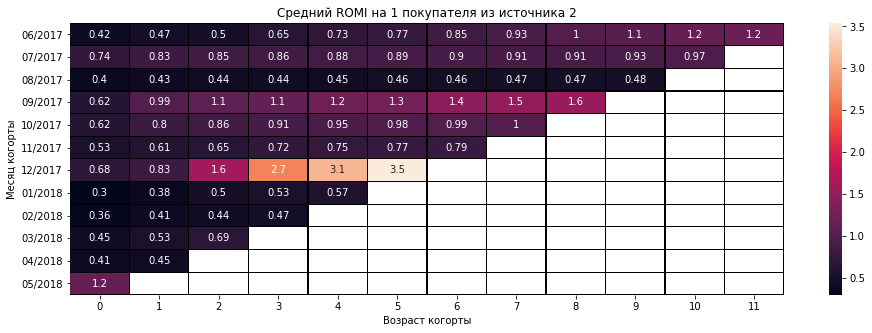

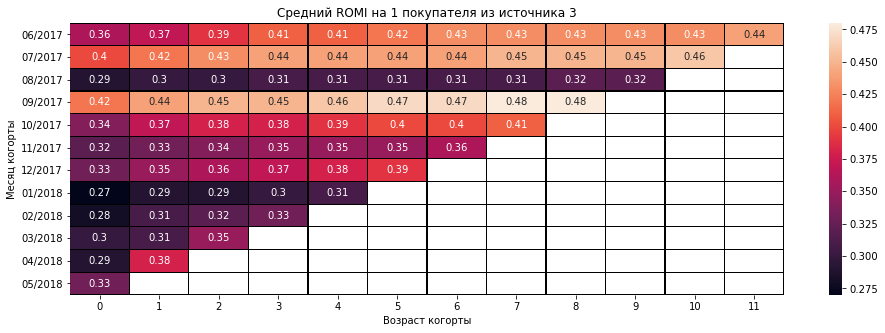

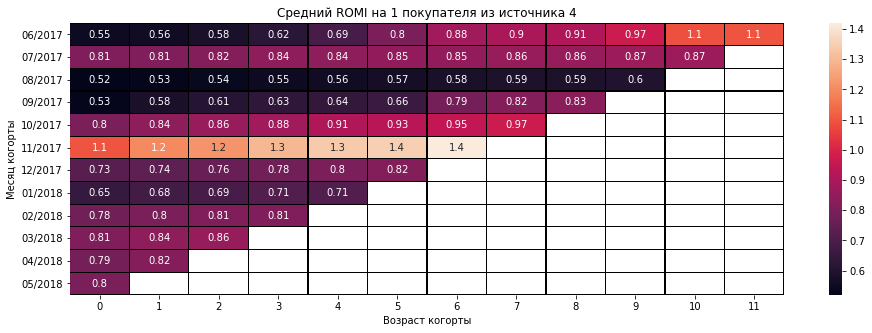

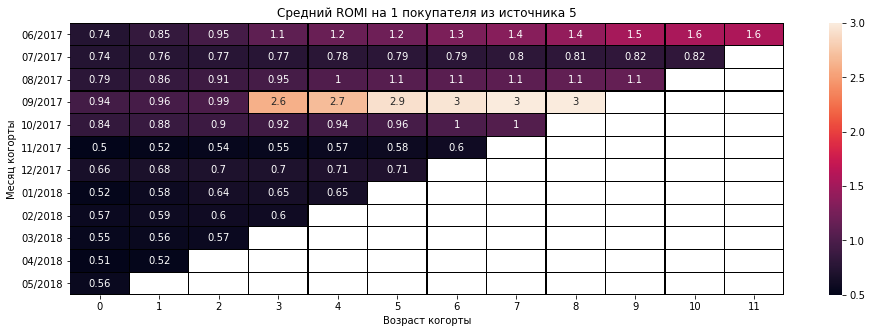

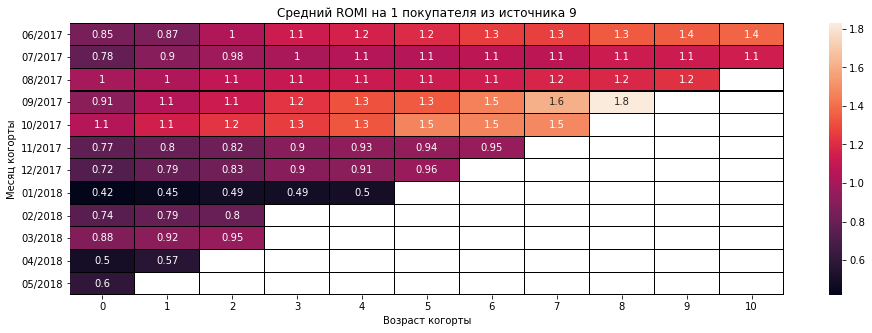

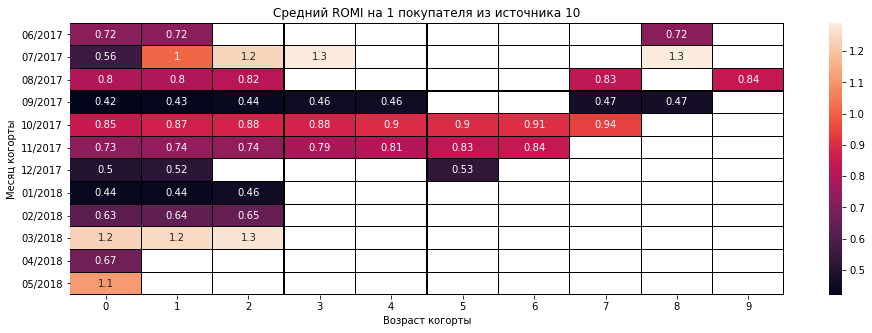

In [111]:
for source in sources:
    plt.figure(figsize=(16, 5))
    
    romi_by_sources = (romi_report[romi_report['source_id'] == source]
              .pivot_table(index='first_buy_month', columns='age', values='romi', aggfunc='mean'))
    romi_by_sources.index = romi_by_sources.index.strftime("%m/%Y")
    
    sns.heatmap(romi_by_sources.cumsum(axis=1).round(2), annot=True, linewidths=0.2, linecolor='black')
    
    plt.title('Средний ROMI на 1 покупателя из источника {}'.format(source))
    plt.xlabel('Возраст когорты')
    plt.ylabel('Месяц когорты')

Изучив графики, мы можем сделать вывод, что наиболее высокий показатель romi, то есть окупаемости маркетинговых инвестиций, набюдается в первом рекламном источнике: июньская когорта за 12 месяцев окупилась больее, чем в 3.5 раза., что касается других когорт по данному источнику - большинство окупились на 1-3 месяц жизни, за исключением когорт декабря - февраля и апреля-мая, которые за период наблюдений так и не окупились.

По второму источнику трафика мы видим, что окупились только некоторые когорты - июня, сентября и октября 2017 г., а также декабря 2017 г. и мая 2018 г. - когорта декабря 2017 г. окупилась за 6 месяцев в 3.5 раза, а мая 2018 г. - уже за 1 месяц сумма, которую в среднем принес клиент превысила расходы на привлечение на 20%.

По третьему источнику трафика ни одна из когорт не окупилась - стомость привлечения клиентов оказалась выше прибыли, которую они принесли.

По четвертому рекламному источнику мы можем отметить, что окупились когорта июня 2017 г., а также ноября 2017 г., по остальным когортам экономика одного покупателя "не сошлась".

По пятому источнику трафика окупились несколько когорт - июня, августа, сентября, октября 2017 г. Особенно выделяется когорта сентября 2017 г. - расходы окупились в три раза за 7 месяцев, однако после 7-го месяца не было никакого роста в показателе romi.

По девятому источнику стабильно окупались на 1-4 месяц "жизни" когорты до ноября 2017 г., когорты ноября и декабря 2017 г. практически окупились к 7-8 месяцу "жизни", после чего показатель romi значительно снизился - когорты января, апреля и мая 2018 г. на первый месяц жизни окупились только примерно на половину.

По десятому источнику у нас отсутствуют данные по большому количеству месяцев. Однако по имеющимся данным мы можем сказать, что окупились только 3 когорты - июля 2017 г., марта и мая 2018 г.


Далее посчитаем romi по средней когорте за каждый месяц жизни.

In [112]:
output = (romi_report
          .pivot_table(index=['source_id', 'first_buy_month'], columns='age', values='romi', aggfunc='mean')
          .cumsum(axis=1)
          .round(2)) 

In [113]:
output.mean(axis=0) 

age
0     0.669048
1     0.726184
2     0.807941
3     0.890702
4     0.949804
5     1.037778
6     1.060789
7     1.104848
8     1.171111
9     1.125263
10    1.310833
11    1.582000
dtype: float64

То есть в среднем когорты окупаются на 6-й месяц существования.

[Возврат к оглавлению](#Старт)

### Вывод

Таким образом на данном этапе мы сделали анализ различных маркетинговых метрик:
* Общую **сумму расходов на маркетинг по источникам** - мы выяснили, что самый дорогой источник - 3й, он дороже остальных источников в несколько раз, а самые дешевые - 9й, 10й и 1й.
* Средний **CAC** на одного покупателя - стоимость привлечения клиента выше всего также по 3му источнику, после которого следует 2й. Наиболее низкий показатель - также по 9му и 10му источникам. Примерно одинаковые показатели у 1го и 5го источников, а показатель по 4 источнику значительно вариируется от месяца к месяцу.
* **ROMI** в разрезе источников - в среднем когорты окупаются на 6й месяц "жизни", при этом некоторые когорты совсем не окупились за рассматриваемый период - это когорты по всем месяцам по 3му источнику. Довольно привлекательными выглядят когорты по 1му и 9му источникам - до октября-ноября 2017 г. они окупались на 1-3 или 1-4 месяц "жизни", однако стоит обратить внимание, что после осени 2017 г. показатель romi по данным когортам снизился, и не все когорты внутри данных источников вышли на окупаемость за рассматриваемый период.

Исходя из всех пунктов, можно отметить, что 3й рекламный источник очень дорогой, и сумма денег, которую клиент приносит в среднем со своих покупок не окупает расходы на него. Стоит либо подумать над тем, как можно снизить показатель сас по данному источнику или повысить ltv по нему.

[Возврат к оглавлению](#Старт)

## Шаг 3. <a id="3"></a>

#### 3.1. Определение приоритетных источников трафика <a id="3.1"></a>

Определим источники трафика, на которые маркетологам стоит делать упор.

Исходя из значений показателя romi, мы можем сделать следующие выводы о различых источниках трафика:
* Источники, на которые **стоит сделать упор** - это 1й, 9й и, возможно, 2й (6-7 когорт по данным источникам окупились) источники. При этом по 1му и 9му источникам после когорт октября-ноября 2017 г. наблюдается снижение показателя romi и последующие после этих когорты не окупаются за рассматривыемый период. По 2му источнику трафика выделяются сентябрьская, декабрьская и майская когорты, по которым инвестиции окупились на 1-3й месяц "жизни" когорты.

* Источники, по которым необходимо снизить стоимость привлечения клиента или повысить "пожизненную" цену клиента для улучшения показателя romi - это 3й источник, также к ним можно отнести 4й и 5й источники (только 3-4 когорты по данным источникам окупились за рассматриваемый период или были очень близки к окупаемости)

[Возврат к оглавлению](#Старт)

#### 3.2. Выводы по каждому виду метрик <a id="3.2"></a>

Опишем выводы после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции.

* По итогам анализа **продуктовых** метрик можно сказать, что 1) пик метрик MAU, DAU и WAU приходится на ноябрь 2017 г., 2) среднее количество посещений сайта в день, которое приходится на каждого клиента, составляет примерно 1 посещение в день, 3) типичная пользовательская сессия длится около 6 минут, а 4) retention rate составляет 6.38%.
* В результате анализа метрик **электронной коммерции** мы можем отметить, что 1) в среднем покупатели совершают первую покупку в тот же день, когда они впервые заходят на сайт, 2) в среднем на каждого покупателя приходится не 1.41 покупка, при этом наиболее высокий показатель - в когорте июня 2017 г., 3) средний чек составляет 4.96 у.е. за покупку, при этом самое высокое значение данного показателя - в декабре 2017 г., 4) в среднем за полгода каждый пользователь приносить компании около 8.38 у.е.
* После анализа **маркетинговых** метрик мы можем сказать, что 1) самый дорогой источник по общей сумме расходов на маркетинг - 3й источник трафика, 2) показатель стоимости привлечения клиента также самый высокий по 3му источнику, 3) за рассматриваемый период мы не видим окупаемости ни одной из когорт по 3му источнику трафика, при этом наиболее высокие показатели romi - в 1м и 9м источниках.

Таким образом, является важным изучить, почему типичная пользовательская сессия длится всего 6 минут, что вызвало значительное увеличение метрик MAU, WAU, DAU в ноябре 2017 г., проанализировать, каким образом мы можем повысить средний чек и ltv, а также  проработать план по выводу 3го источника трафика на окупаемость маркетинговых инвестиций.

[Возврат к оглавлению](#Старт)

#### 3.3. Определение самых перспективных для компании когорт <a id="3.3"></a>

Подведем итоги когортного анализа - оределим самые перспективные для компании когорты клиентов.

Наиболее перспективными когортами с точки зрения **retention rate** являются когорта июня 2017 г. (с самыми высокими показателями retention rate), когортах августа, сентября, октября и ноября 2017 г.

С точки зрения показателя ltv - наиболее перспективные когорты - когорта сентября 2017 г. (за весь наблюдаемый срок "жизни" показатели данной когорты являются самыми высокими) и июня 2017 г.

С точки зрения romi по источникам - самые перспективные когорты - когорты июня-ноября 2017 г. по 1му источнику, когорты июня-октября 2017 г. по 9му источнику, и когорты сентября, декабря 2017 г., а также мая 2017 г. по 2му источнику.

Таким образом, если рассматривать когорты с точки зрения всех 3х метрик - retantion rate, ltv, romi в разбивке по источникам, то самые хорошие показатели - в когортах июня и сентября 2017 г.

[Возврат к оглавлению](#Старт)